In [5]:
import os, random, cv2, time, glob, pickle, datetime
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.image as mping
import matplotlib.pyplot as plt
from keras.models import model_from_json, Sequential
from keras.utils import np_utils
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.utils import np_utils
import h5py

use_cache = 1
ranndom_state = 1031
np.random.seed(2017)

%matplotlib inline

## 探索数据集

In [2]:
lable_dict = {  'c0': 'safe driving',
                'c1': 'texting - right',
                'c2': 'talking on the phone - right',
                'c3': 'texting - left',
                'c4': 'talking on the phone - left',
                'c5': 'operating the radio',
                'c6': 'drinking',
                'c7': 'reaching behind',
                'c8': 'hair and makeup',
                'c9': 'talking to passenger'  }

def display_stat():
    cwd = os.getcwd()
    train_list = os.listdir(os.path.join(cwd, 'train'))
    lable_counts = {}
    for i in train_list:
        lable_counts[i] = (len(os.listdir(os.path.join(cwd, 'train/%s' % i))))
    print('\nLabel Counts: %s' % lable_counts)
    print('Samples: %d' % sum(lable_counts.values()))
    
    sample_behavior = random.choice(list(lable_dict.keys()))
    sample_image_name = random.choice(os.listdir(os.path.join(cwd, 'train/%s' % sample_behavior)))
    sample_image = mping.imread('./train/%s/%s' % (sample_behavior, sample_image_name))
    print('\nExample of Image %s:' % sample_image_name)
    print('Image Shape: %s' % str(sample_image.shape))
    print('Label Id: %s Behavior: %s' % (sample_behavior, lable_dict[sample_behavior]))
    
    plt.imshow(sample_image)
    plt.axis('off')
    plt.show()


Label Counts: {'c8': 1911, 'c6': 2325, 'c0': 2489, 'c4': 2326, 'c1': 2267, 'c3': 2346, 'c5': 2312, 'c7': 2002, 'c2': 2317, 'c9': 2129}
Samples: 22424

Example of Image img_51590.jpg:
Image Shape: (480, 640, 3)
Label Id: c4 Behavior: talking on the phone - left


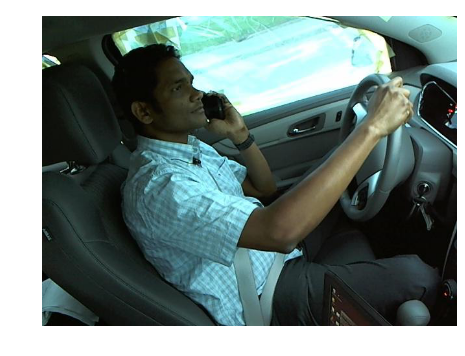

In [3]:
display_stat()

In [3]:
img = cv2.imread('./train/c1/img_100021.jpg')

In [32]:
def cv2_show(img):
    cv2.namedWindow('the window')
    cv2.imshow('the window', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [22]:
def get_im_cv2(img_path):
    #  cv2.INTER_LINEAR 表示图像压缩的一种方法
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224), cv2.INTER_LINEAR)
    return img

In [16]:
def get_driver_data():
    dr = dict()
    clss = dict()
    path = os.path.join('.', 'data', 'driver_imgs_list.csv')
    print('Read drivers data')
    with open(path, 'r') as f:
        _ = f.readline()
        for line in f.readlines():
            arr = line.strip().split(',')
            dr[arr[2]] = arr[0]
            if arr[0] not in clss.keys():
                clss[arr[0]] = [(arr[1], arr[2])]
            else:
                clss[arr[0]].append((arr[1], arr[2]))
    return dr, clss

In [25]:
def load_train():
    X_train = []
    X_train_id = []
    y_train = []
    driver_id = []
    start_time = time.time()
    driver_data, dr_class = get_driver_data()

    print('Read train images')
    for j in tqdm(range(10)):
        print('Load folder c{}'.format(j))
        path = os.path.join('.', 'data', 'train', 'c' + str(j), '*.jpg')
        files = glob.glob(path)
        for fl in files:
            flbase = os.path.basename(fl)
            img = get_im_cv2(fl, (224, 224))
            X_train.append(img)
            X_train_id.append(flbase)
            y_train.append(j)
            driver_id.append(driver_data[flbase])

    print('Read train data time: {} seconds'.format(round(time.time() - start_time, 2)))
    unique_drivers = sorted(list(set(driver_id)))
    print('Unique drivers: {}'.format(len(unique_drivers)))
    print(unique_drivers)
    return X_train, y_train, X_train_id, driver_id, unique_drivers

In [26]:
X_train, y_train, X_train_id, driver_id, unique_drivers = load_train()

Read drivers data
Read train images


  0%|          | 0/10 [00:00<?, ?it/s]

Load folder c0


 10%|█         | 1/10 [00:12<01:55, 12.83s/it]

Load folder c1


 20%|██        | 2/10 [00:25<01:41, 12.66s/it]

Load folder c2


 30%|███       | 3/10 [00:37<01:28, 12.64s/it]

Load folder c3


 40%|████      | 4/10 [00:50<01:17, 12.84s/it]

Load folder c4


 50%|█████     | 5/10 [01:03<01:04, 12.82s/it]

Load folder c5


 60%|██████    | 6/10 [01:18<00:54, 13.51s/it]

Load folder c6


 70%|███████   | 7/10 [01:33<00:41, 13.77s/it]

Load folder c7


 80%|████████  | 8/10 [01:47<00:27, 13.81s/it]

Load folder c8


 90%|█████████ | 9/10 [02:18<00:19, 19.05s/it]

Load folder c9


100%|██████████| 10/10 [02:33<00:00, 17.99s/it]


Read train data time: 153.98 seconds
Unique drivers: 26
['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']


In [13]:
def split_list(wanted_parts=1):
    path = os.path.join('.', 'data', 'test', '*.jpg')
    files = sorted(glob.glob(path))
    length = len(files)
    return [files[i*length // wanted_parts: (i+1)*length // wanted_parts] for i in range(wanted_parts)]

def load_test(split_files_list):
    X_test = []
    X_test_id = []
    print('Start image: ' + str(split_files_list[0]))
    print('Last image: ' + str(split_files_list[-1]))
    for fl in split_files_list:
        flbase = os.path.basename(fl)
        img = get_im_cv2(fl)
        X_test.append(img)
        X_test_id.append(flbase)

    return X_test, X_test_id

In [12]:
def cache_data(data, path):
    if os.path.isdir(os.path.dirname(path)):
        file = open(path, 'wb')
        pickle.dump(data, file)
        file.close()
    else:
        print('Directory doesnt exists')
        
def restore_data(path):
    if os.path.isfile(path):
        file = open(path, 'rb')
        data = pickle.load(file)
    return data

In [ ]:
def save_model(model):
    json_string = model.to_json()
    if not os.path.isdir('model'):
        os.mkdir('model')
    open(os.path.join('model', 'architecture_vgg16.json'), 'w').write(json_string)
    model.save_weights(os.path.join('model', 'model_weights_vgg16.h5'), overwrite=True)


def read_model():
    model = model_from_json(open(os.path.join('model', 'architecture_vgg16.json')).read())
    model.load_weights(os.path.join('model', 'model_weights_vgg16.h5'))
    return model

In [11]:
def create_submission(predictions, test_id, info):
    result = pd.DataFrame(predictions, columns=['c'+'%s' %i for i in range(10)])
    result['img'] = test_id
    now = datetime.datetime.now()
    if not os.path.isdir('submission'):
        os.mkdir('submission')
    suffix = info + ' ' + now.strftime('%Y%m%d_%H%M')
    result.to_csv(os.path.join('submission', suffix + '.csv'), index=False)

In [ ]:
def read_and_normalize_train_data():
    cache_path = os.path.join('cache', 'train_r_' + str(224) + '_c_' + str(224) + '_t_' + str(3) + '.dat')
    if not os.path.isfile(cache_path) or use_cache == 0:
        train_data, train_target, train_id, driver_id, unique_drivers = load_train()
        cache_data((train_data, train_target, train_id, driver_id, unique_drivers), cache_path)
    else:
        print('Restore train from cache!')
        (train_data, train_target, train_id, driver_id, unique_drivers) = restore_data(cache_path)

    print('Convert to numpy...')
    train_data = np.array(train_data, dtype=np.uint8)
    train_target = np.array(train_target, dtype=np.uint8)

    print('Reshape...')
    train_data = train_data.transpose((0, 3, 1, 2))

    print('Convert to float...')
    train_data = train_data.astype('float16')
    mean_pixel = [103.939, 116.779, 123.68]
    print('Substract 0...')
    train_data[:, 0, :, :] -= mean_pixel[0]
    print('Substract 1...')
    train_data[:, 1, :, :] -= mean_pixel[1]
    print('Substract 2...')
    train_data[:, 2, :, :] -= mean_pixel[2]

    train_target = np_utils.to_categorical(train_target, 10)

    # Shuffle experiment START !!!
    perm = permutation(len(train_target))
    train_data = train_data[perm]
    train_target = train_target[perm]
    # Shuffle experiment END !!!

    print('Train shape:', train_data.shape)
    return train_data, train_target, train_id, driver_id, unique_drivers


def read_and_normalize_test_data(split_file_list):
    start_time = time.time()
    cache_path = os.path.join('cache', 'test_r_' + str(224) +
                              '_c_' + str(224) +
                              '_part_' + str(part) +
                              '.dat')
    if not os.path.isfile(cache_path) or use_cache == 0:
        test_data, test_id = load_test(split_file_list)
        cache_data((test_data, test_id), cache_path)
    else:
        print('Restore test from cache [{}]!'.format(part))
        (test_data, test_id) = restore_data(cache_path)

    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.transpose((0, 3, 1, 2))

    test_data = test_data.astype('float16')
    mean_pixel = [103.939, 116.779, 123.68]
    test_data[:, 0, :, :] -= mean_pixel[0]
    test_data[:, 1, :, :] -= mean_pixel[1]
    test_data[:, 2, :, :] -= mean_pixel[2]

    print('Test shape:', test_data.shape)
    print('Read and process test data time: {} seconds'.format(round(time.time() - start_time, 2)))
    return test_data, test_id

In [ ]:
def VGG_16():
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(3, 224, 224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), stride=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), stride=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), stride=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), stride=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), stride=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    f = h5py.File('weights/vgg16_weights.h5')
    for k in range(f.attrs['nb_layers']):
        if k >= len(model.layers):
            # we don't look at the last (fully-connected) layers in the savefile
            break
        g = f['layer_{}'.format(k)]
        weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
        model.layers[k].set_weights(weights)
    f.close()
    print('Model loaded.')

    model.add(Dense(10, activation='softmax'))

    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy')

    return model

In [ ]:
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

In [ ]:
def run_cross_validation_create_models(nfolds=10):
    # input image dimensions
    batch_size = 16
    nb_epoch = 25
    restore_from_last_checkpoint = 1

    train_data, train_target, train_id, driver_id, unique_drivers = read_and_normalize_train_data()

    yfull_train = dict()
    kf = KFold(len(unique_drivers), n_folds=nfolds, shuffle=True, random_state=random_state)
    num_fold = 0
    sum_score = 0
    for train_drivers, test_drivers in kf:
        model = VGG_16()
        unique_list_train = [unique_drivers[i] for i in train_drivers]
        X_train, Y_train, train_index = copy_selected_drivers(train_data, train_target, driver_id, unique_list_train)
        unique_list_valid = [unique_drivers[i] for i in test_drivers]
        X_valid, Y_valid, test_index = copy_selected_drivers(train_data, train_target, driver_id, unique_list_valid)

        num_fold += 1
        print('Start KFold number {} from {}'.format(num_fold, nfolds))
        print('Split train: ', len(X_train), len(Y_train))
        print('Split valid: ', len(X_valid), len(Y_valid))
        print('Train drivers: ', unique_list_train)
        print('Test drivers: ', unique_list_valid)

        kfold_weights_path = os.path.join('cache', 'weights_kfold_vgg16_' + str(num_fold) + '.h5')
        if not os.path.isfile(kfold_weights_path) or restore_from_last_checkpoint == 0:
            callbacks = [
                EarlyStoppingByLossVal(monitor='val_loss', value=0.00001, verbose=1),
                EarlyStopping(monitor='val_loss', patience=5, verbose=0),
                ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True, verbose=0),
            ]
            model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
                  shuffle=True, verbose=1, validation_data=(X_valid, Y_valid),
                  callbacks=callbacks)
        if os.path.isfile(kfold_weights_path):
            model.load_weights(kfold_weights_path)

        # score = model.evaluate(X_valid, Y_valid, show_accuracy=True, verbose=0)
        # print('Score log_loss: ', score[0])

        predictions_valid = model.predict(X_valid.astype('float32'), batch_size=batch_size, verbose=1)
        score = log_loss(Y_valid, predictions_valid)
        print('Score log_loss: ', score)
        sum_score += score*len(test_index)

        # Store valid predictions
        for i in range(len(test_index)):
            yfull_train[test_index[i]] = predictions_valid[i]

    score = sum_score/len(train_data)
    print("Log_loss train independent avg: ", score)

    predictions_valid = get_validation_predictions(train_data, yfull_train)

    print('Final log_loss: {}, nfolds: {} epoch: {}'.format(score, nfolds, nb_epoch))
    info_string = 'loss_' + str(score) \
                    + '_folds_' + str(nfolds) \
                    + '_ep_' + str(nb_epoch)

    save_useful_data(predictions_valid, train_id, model, info_string)

    score1 = log_loss(train_target, predictions_valid)
    if abs(score1 - score) > 0.0001:
        print('Check error: {} != {}'.format(score, score1))
